<a href="https://colab.research.google.com/github/tomgoter/w207_finalproject/blob/master/basic_cnn_example_ctw.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Facial Keypoint Detection
## Demonstration of a simple Convolutional Neural Network
### Chris Weyandt  -  W207 Final Project - Summer 2019


This example notebook, developed in the Google Colaboratory environment, is a demonstration of a simple workflow to predict facial keypoints using the keras interface to tensorflow.  

- Dataset
 - We start by loading a dataset containing 2041 images, each paired with a set of 15 `(x,y)` coordinates defining specific facial keypoints such as `nose_center` and `right_eye_center`. 
  - The data is loaded by default from your google drive in a folder named `FacialKeypointDetection`. 
  - The data file, df_nostache_nonan.pkl is 151MB and cannot be shared via github. As such, it can be downloaded from here https://drive.google.com/file/d/1MtVbNeVyDf3emq8FrQ7nyMwWp_FuoKCL/view 
  - The data file can also be generated from our DataExploration.ipynb notebook located in the project github repo at https://github.com/tomgoter/w207_finalproject/blob/master/DataExploration.ipynb



- Resouces 
 - Our team's final project github repo:  https://github.com/tomgoter/w207_finalproject
 - A nice tutorial:  https://medium.com/deep-learning-turkey/google-colab-free-gpu-tutorial-e113627b9f5d

# Imports



In [1]:
# Import tensorflow and check the version - we will be using version 1.14
import tensorflow as tf
print(tf.__version__)

# Import standard packages
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline
import os

# Import libraries for integrating the colaboratory notebook to google drive
# Comment this out if running in a local notebook
from google.colab import drive

# Import libraries from the tensorflow.keras interface
from tensorflow.keras import models, callbacks
from tensorflow.keras import optimizers, metrics
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, InputLayer, Conv2D, Flatten, Activation, BatchNormalization, MaxPooling2D, Dropout
from tensorflow.keras.utils import plot_model

# Import liraries to display model plots inline8
#from IPython.display import SVG
#from tensorflow.keras.utils import model_to_dot

1.14.0


In [0]:
# Check to see whether the livelossplot library has already been installed on this colab instance
# This will execute once per session to install the needed libraries
import importlib
if importlib.util.find_spec("livelossplot") is None:
  !pip install livelossplot

# Import the PlotLossesCallback, which is used to visualize model training performance.
from livelossplot.tf_keras import PlotLossesCallback

## Clean up keras backend

In [0]:
# Clean up your session, clearing existing graph data from the keras backend.
tf.keras.backend.clear_session()

## Import our data from our drive
- Load in the pickle file that was created as part of the EDA in DataExploration.ipynb.
- This dataset has the NaNs removed and a few mislabeled images removed as well.
- As such there is only limited training and development data to use.
- The image data has already been normalized to [0,1]

### Choose whether to load files locally or from google drive

In [0]:
# 0 = Local, 1 = Google Drive
drive_source = 1

if drive_source:
  # Mounting the drive is straightforward but requires authentication each time a new colab session is started
  # we reset the session
  drive.mount('/content/drive', force_remount=True)
  drive_path = '/content/drive/My Drive/FacialKeypointDetection/'
  # list the contents of the drive
  ! ls /content/drive/My\ Drive/FacialKeypointDetection/
else:
  drive_path = './'

### Load dataset

In [5]:
# Load the dataframe from the pickle file
df_nostache_nonan = pd.read_pickle(drive_path + "df_nostache_nonan.pkl")

# Grab the last column - that is our image data for X matrix
X = df_nostache_nonan.iloc[:, -1]

# Convert from a series of arrays to an NDarray
X = np.array([x.reshape(96,96,1) for x in X])

# Grab the keypoints and stick into our y-variable
y = np.array(df_nostache_nonan.iloc[:,:-1])

X.shape

(2140, 96, 96, 1)

## Instantiate callbacks

- `callbacks.EarlyStopping()` monitors the validation loss and terminates the training session if there is a lack of progress.

- `PlotLossesCallback`, when combined with the flag `verbose=0`, replaces the standard textual output of the model fit process with regularly updating plots of the loss function and additional metrics as specified in the `model.compile` statement.


In [0]:
# The early stop callback will terminate a training session if no progress is being made
early_stop = callbacks.EarlyStopping(monitor='val_loss', min_delta=0.1,
                              patience=100, mode='auto')

# The plot_losses callback will display a plot of RMSE and Accuracy 
# and auto-update the plot every few epochs during the training session.
plot_losses = PlotLossesCallback()

# Create Helper functions
These functions will streamline the process of building and visualizing our models and their results.

## Train the Model

The following information is useful to know when setting up our model:

**batch_size**
Determines the number of samples in each mini batch. Its maximum is the number of all samples, which makes gradient descent accurate, the loss will decrease towards the minimum if the learning rate is small enough, but iterations are slower. Its minimum is 1, resulting in stochastic gradient descent: Fast but the direction of the gradient step is based only on one example, the loss may jump around. batch_size allows to adjust between the two extremes: accurate gradient direction and fast iteration. Also, the maximum value for batch_size may be limited if your model + data set does not fit into the available (GPU) memory.

**steps_per_epoch**
The number of batch iterations before a training epoch is considered finished. If you have a training set of fixed size you can ignore it but it may be useful if you have a huge data set or if you are generating random data augmentations on the fly, i.e. if your training set has a (generated) infinite size. If you have the time to go through your whole training data set I recommend to skip this parameter.

**validation_steps**
similar to steps_per_epoch but on the validation data set instead on the training data. If you have the time to go through your whole validation data set I recommend to skip this parameter.

**callback references**
https://gist.github.com/stared/dfb4dfaf6d9a8501cd1cc8b8cb806d2e

In [0]:
def BuildModel( model, epochs = 100, val_split = 0.3):
  # epochs = 100
  # val_split = 0.3

  plot_losses = PlotLossesCallback()

  #Compile the model
  model.compile(optimizer=tf.train.AdamOptimizer(), 
                loss='mean_squared_error', 
                metrics=['accuracy'])

  history = model.fit(
      X, y,
      epochs=epochs,
      batch_size=32,
      validation_split = val_split,
      callbacks=[plot_losses, early_stop],
      verbose=0)

## Visualizing Convolutions

In [0]:
def VisualizeConvolutions( model, layer_names=[], depth=6, img_idx=2011, show_points=False, save_img=False, filename='simple_cnn_pred'):
  if len(layer_names) < 1:
    layer_names = ['3x3Kernel']

  labels = layer_names

  # Create subplot space, remove x,y ticks, and flatten axes for easy indicing
  fig, axes = plt.subplots(2*len(layer_names), 3, figsize=(18, 12*len(layer_names)),
                          subplot_kw={'xticks':[],'yticks':[]})
  axes = axes.flatten()

  # Iterate through the depths of the supplied layers, generating a prediction for the target
  # image based on the weights at each depth of the convolution
  # Do this by creating a new, simple model from the weights in our previously trained model.
  for i in range(depth):
    for l, layer in enumerate(layer_names):
      # Import the requested layer from the supplied model
      intermediate_layer_model = models.Model(inputs=model.input,
                                        outputs=model.get_layer(name=layer).output)
      
      # Generate predictions for the supplied image using the weights from a specific depth of the layer
      intermediate_output = intermediate_layer_model.predict([X[img_idx].reshape(1,96,96,1)])
      
      # Reshape the predictions to a 96x96x1 image
      pixels = len(intermediate_output[0,:,:1])
      plot_data = intermediate_output[0,:,:,i].reshape(pixels,pixels)
      
      # Plot the resulting images
      axes[l*depth+i].imshow(plot_data,cmap='gray_r')
      axes[l*depth+i].set_title(layer + " Depth[%i]" %i)
  
  # Save a copy of the image, if so desired
  if not save_img:
    fig.savefig(drive_path + "/viz/" + filename + ".png")  

## Visualizing predictions

In [0]:
def VisualizePredictions( model, X=X, actuals=y, start_img=142, val_split=0.7, save_img=False, filename='pred_img'):
  
  # Calculate an offset for plotting the validation images
  val_offset = int(len(y) * val_split)
  # Make sure we don't overrun the end of the data
  if start_img + val_offset > len(y):
    start_img = 100

  # Predict 15 facial keypoints for every image in X
  predictions = simple_cnn.predict(X)

  # Define our subplots with no ticks
  fig, axes = plt.subplots(2,3, figsize=(18,12), subplot_kw={'xticks':[],'yticks':[]})
  axes = axes.flatten()

  # Map out the coordinates from both the predictions and the actuals for easy indexing
  xs = predictions[:,0:30:2]
  ys = predictions[:,1:30:2]
  x_act = actuals[:,0:30:2]
  y_act = actuals[:,1:30:2]

  # Iterate through two rows of images. 
  # First row will show predictions on training image
  # Second row will show predictions on validation images
  for i, ax in enumerate(axes):
      if i >= len(axes)/2: 
        offset = start_img + val_offset + i
        ax.set_title("Validation Image")
      else:
        offset = start_img + i
        ax.set_title("Training Image")
      ax.imshow(np.reshape(X[offset],(96,96)), origin='upper', cmap='gray')
      
      # Plot predictions in red
      ax.scatter(x=xs[offset,:], y=ys[offset,:], color='red')
      
      # Plot actuals in yellow, and smaller
      ax.scatter(x=x_act[offset,:], y=y_act[offset,:], color='yellow', s=6)

  # Save a copy of the image, if so desired
  if not save_img:    
    fig.savefig(drive_path + "/viz/" + filename + ".png") 


In [0]:
# SVG(model_to_dot(model, show_shapes=True).create(prog='dot', format='svg'))

# Create a simple CNN model

- Nice blog post: https://www.analyticsvidhya.com/blog/2017/06/architecture-of-convolutional-neural-networks-simplified-demystified/
- https://hackernoon.com/visualizing-parts-of-convolutional-neural-networks-using-keras-and-cats-5cc01b214e59

In [11]:
# Create a simple sequential cnn model
simple_cnn = Sequential()

# Take in a 96x96 pixel grayscale image
simple_cnn.add(InputLayer(input_shape=(96,96,1), name='Image'))

# Perform convolution with a 3x3 kernel with a depth of six 
simple_cnn.add(Conv2D(6, (3,3), padding='same', activation='relu', name='3x3Kernel'))

# Convert to 1D representation (a simple neural net)
simple_cnn.add(Flatten(name='ToSimpleNet'))

# Convert to feature space representing the 30 keypoint parameters
simple_cnn.add(Dense(30, name='To30Features'))

# Predict outputs
simple_cnn.add(Activation('linear', name='Predict'))

# Plot a diagram of the model
plot_model(simple_cnn, to_file=drive_path + 'viz/simple_cnn_plot.png', show_shapes=True, show_layer_names=True)
simple_cnn.summary()

W0806 22:02:32.921725 140498962503552 deprecation.py:506] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/init_ops.py:1251: calling VarianceScaling.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
3x3Kernel (Conv2D)           (None, 96, 96, 6)         60        
_________________________________________________________________
ToSimpleNet (Flatten)        (None, 55296)             0         
_________________________________________________________________
To30Features (Dense)         (None, 30)                1658910   
_________________________________________________________________
Predict (Activation)         (None, 30)                0         
Total params: 1,658,970
Trainable params: 1,658,970
Non-trainable params: 0
_________________________________________________________________


## Build and train the simple cnn

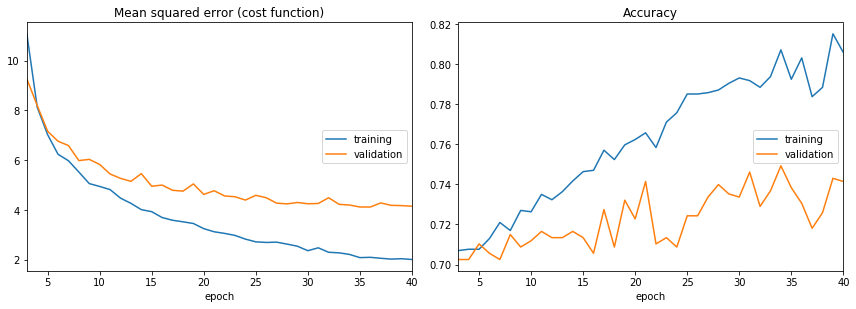

Mean squared error (cost function):
training   (min:    2.006, max:  383.108, cur:    2.006)
validation (min:    4.116, max:  138.854, cur:    4.150)

Accuracy:
training   (min:    0.582, max:    0.815, cur:    0.806)
validation (min:    0.702, max:    0.749, cur:    0.741)


In [12]:
BuildModel( simple_cnn, epochs=40)

## Simple net predictions

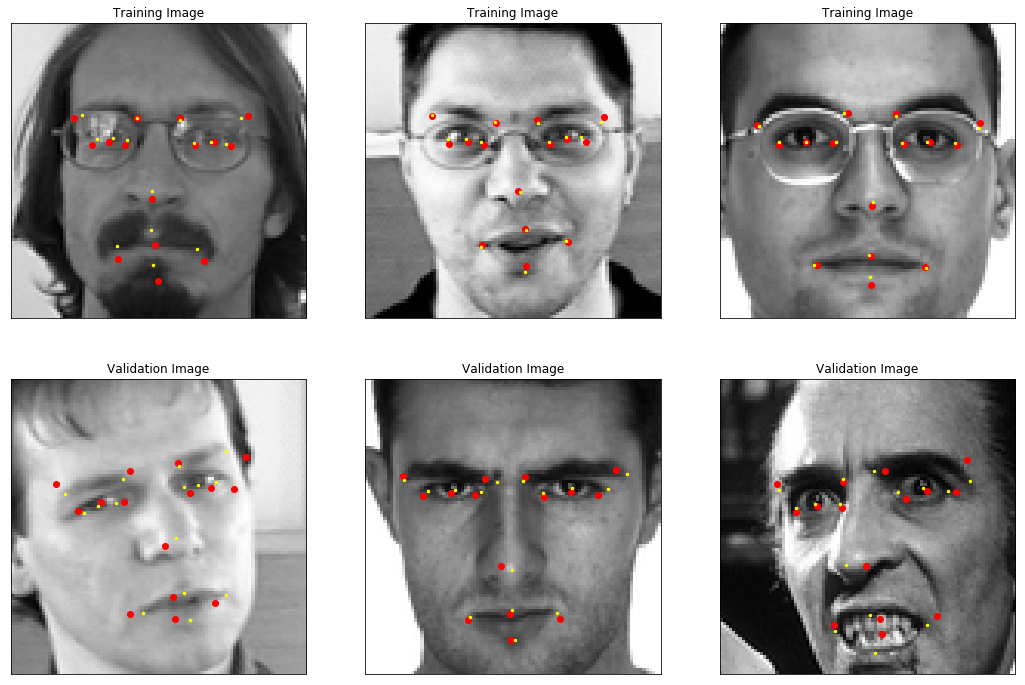

In [13]:
VisualizePredictions( simple_cnn )

## Single 3x3 Convolution

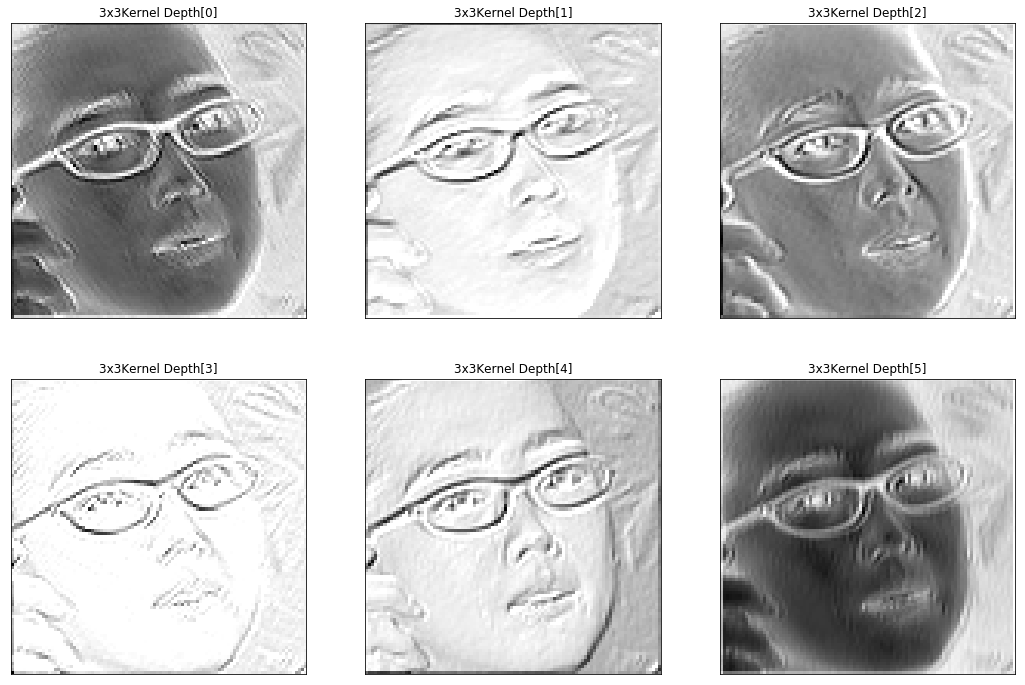

In [14]:
VisualizeConvolutions( simple_cnn, layer_names=['3x3Kernel'])

# Create a deeper CNN model

In [15]:
# Create a double convolution sequential cnn model
deeper_cnn = Sequential()

# Take in a 96x96 pixel grayscale image
deeper_cnn.add(InputLayer(input_shape=(96,96,1), name='Image'))

# Perform convolution with a 3x3 kernel with a depth of six 
deeper_cnn.add(Conv2D(6, (3,3), padding='same', activation='relu', name='3x3Kernel'))

# Perform convolution with a 4x4 kernel
deeper_cnn.add(Conv2D(24, (4,4), padding='same', activation='relu', name='4x4Kernel'))

# Convert to 1D representation (a simple neural net)
deeper_cnn.add(Flatten(name='ToSimpleNet'))

# Convert to feature space representing the 30 keypoint parameters
deeper_cnn.add(Dense(30, name='To30Features'))

# Predict outputs
deeper_cnn.add(Activation('linear', name='Predict'))

# Plot a diagram of the model
plot_model(deeper_cnn, to_file=drive_path + 'viz/deeper_cnn_plot.png', show_shapes=True, show_layer_names=True)
deeper_cnn.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
3x3Kernel (Conv2D)           (None, 96, 96, 6)         60        
_________________________________________________________________
4x4Kernel (Conv2D)           (None, 96, 96, 24)        2328      
_________________________________________________________________
ToSimpleNet (Flatten)        (None, 221184)            0         
_________________________________________________________________
To30Features (Dense)         (None, 30)                6635550   
_________________________________________________________________
Predict (Activation)         (None, 30)                0         
Total params: 6,637,938
Trainable params: 6,637,938
Non-trainable params: 0
_________________________________________________________________


## Train the deeper model

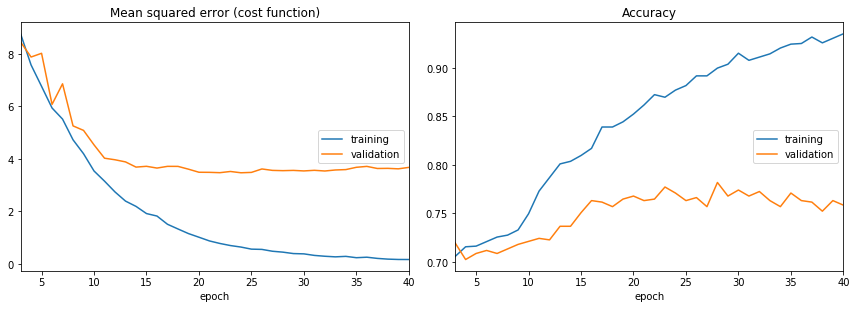

Mean squared error (cost function):
training   (min:    0.166, max:  368.058, cur:    0.166)
validation (min:    3.470, max:   56.954, cur:    3.675)

Accuracy:
training   (min:    0.615, max:    0.935, cur:    0.935)
validation (min:    0.702, max:    0.782, cur:    0.759)


In [16]:
BuildModel( deeper_cnn, epochs=40 )

## Deeper net predictions

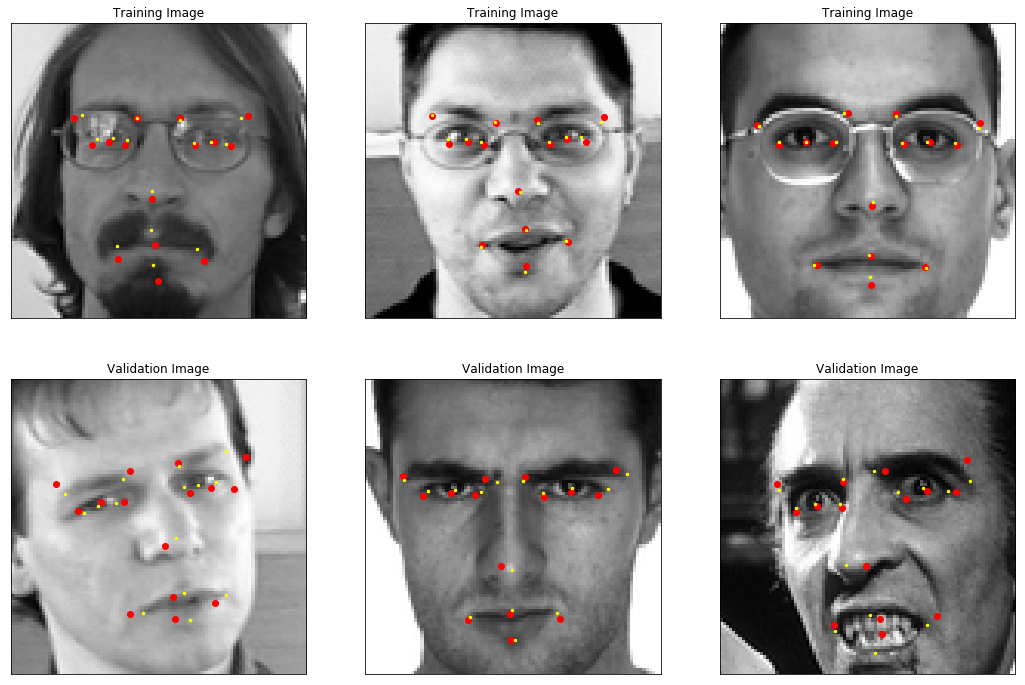

In [17]:
VisualizePredictions( deeper_cnn )

## Deeper convolution layers

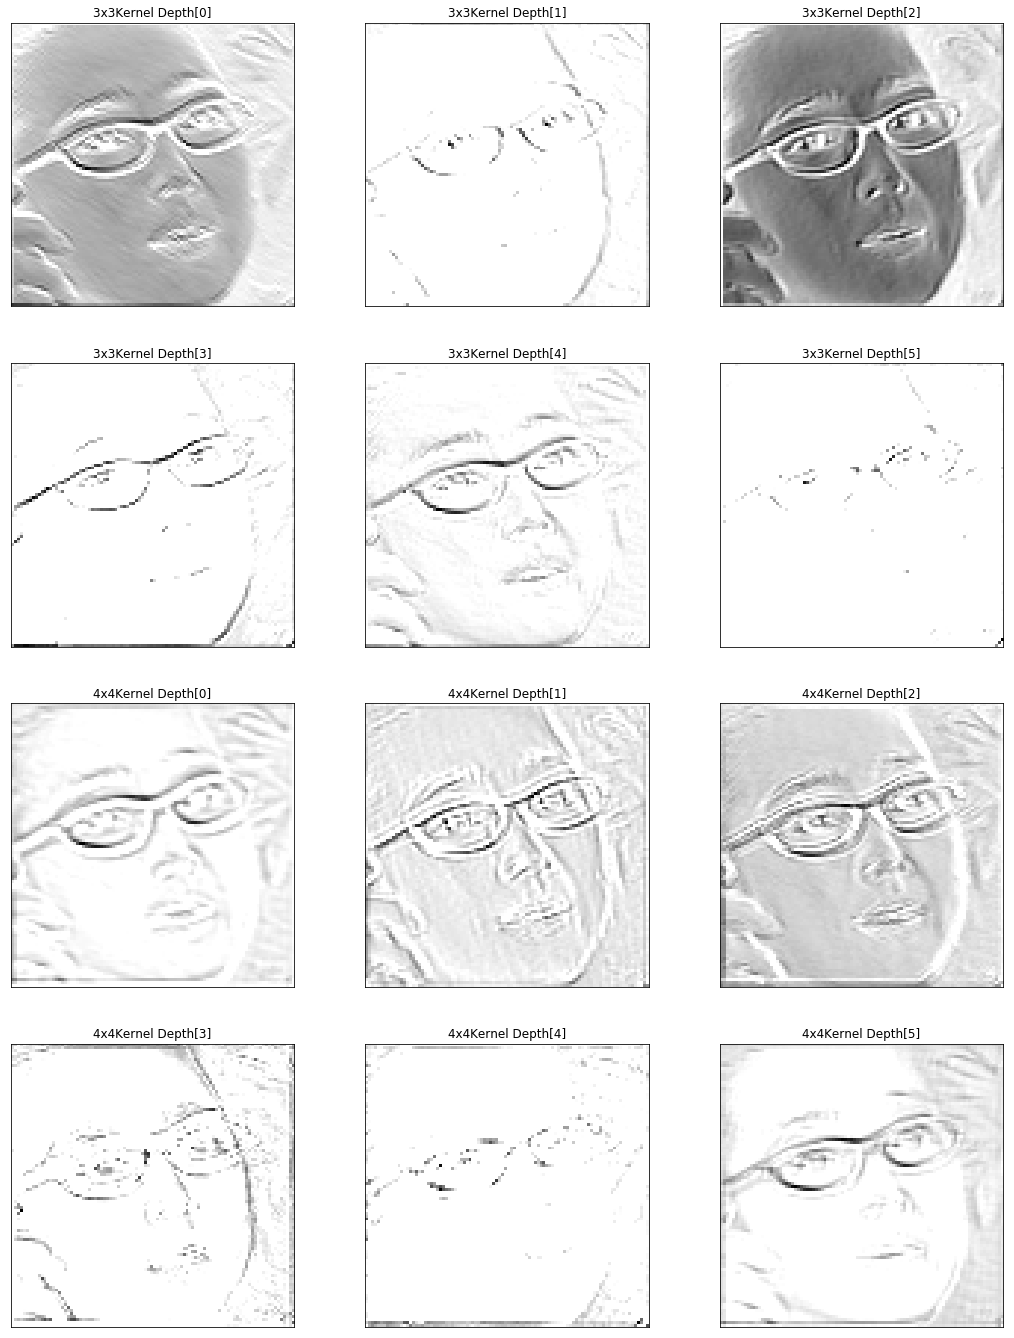

In [18]:
VisualizeConvolutions( deeper_cnn, ['3x3Kernel', '4x4Kernel'])